In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

2023-09-13 13:43:49.557453: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-13 13:43:49.611182: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-13 13:43:49.612442: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-13 13:43:50.561752: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillageCombined1000-2 - Copy/Train/",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
)

Found 11814 files belonging to 13 classes.


In [4]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Black_mold',
 'Tomato__Gray_spot',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato__powdery_mildew',
 'Tomato_healthy']

In [5]:
def get_dataset_partitions_tf(ds, train_split=0.9, val_split=0.1, test_split=0.0, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [6]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [7]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [9]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [10]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
def preprocess_data(image, label):
    image = resize_and_rescale(image)
    image = data_augmentation(image)
    label = tf.one_hot(label, depth=13)  # Convert label to one-hot encoded format
    return image, label

train_ds = train_ds.map(preprocess_data)
val_ds = val_ds.map(preprocess_data)
test_ds = test_ds.map(preprocess_data)


In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [13]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [14]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (256,256) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [15]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 128, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 128, 128, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 128, 128, 32)         0         ['bn_Conv1[

In [16]:
len(base_model.layers)

fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [17]:
last_layer = base_model.get_layer('out_relu')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Reshape((1, 1, 512))(x)
x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x)  # Adjust padding to 'same'
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x)  # Adjust padding to 'same'
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(13, activation='softmax')(x)





In [18]:
model = tf.keras.Model(base_model.input, x)


In [19]:
model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['acc'])

In [20]:
mobile_net_classifier = model.fit(train_ds,
epochs = 20,
validation_data=val_ds,
batch_size = BATCH_SIZE,
verbose = 1)

Epoch 1/20
333/333 [==============================] - 218s 625ms/step - loss: 1.4966 - acc: 0.5066 - val_loss: 3.8189 - val_acc: 0.0682
Epoch 2/20
333/333 [==============================] - 206s 616ms/step - loss: 0.6458 - acc: 0.8026 - val_loss: 4.7962 - val_acc: 0.1511
Epoch 3/20
333/333 [==============================] - 201s 602ms/step - loss: 0.4669 - acc: 0.8600 - val_loss: 2.9751 - val_acc: 0.2789
Epoch 4/20
333/333 [==============================] - 203s 609ms/step - loss: 0.3624 - acc: 0.8893 - val_loss: 3.6920 - val_acc: 0.2245
Epoch 5/20
333/333 [==============================] - 205s 613ms/step - loss: 0.3244 - acc: 0.9044 - val_loss: 1.9818 - val_acc: 0.4352
Epoch 6/20
333/333 [==============================] - 199s 595ms/step - loss: 0.2940 - acc: 0.9120 - val_loss: 2.6170 - val_acc: 0.2746
Epoch 7/20
333/333 [==============================] - 202s 604ms/step - loss: 0.2397 - acc: 0.9249 - val_loss: 1.2657 - val_acc: 0.6321
Epoch 8/20
333/333 [============================

In [21]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillageCombined1000-2 - Copy/Test/",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
)

Found 1404 files belonging to 13 classes.


In [22]:
test_ds = test_ds.map(preprocess_data)

In [23]:
model.save("PlantVillageCombined1000-2 - Copy/MobileNet_fine_tuned_2/")

INFO:tensorflow:Assets written to: PlantVillageCombined1000-2 - Copy/MobileNet_fine_tuned/assets


INFO:tensorflow:Assets written to: PlantVillageCombined1000-2 - Copy/MobileNet_fine_tuned/assets


In [24]:
scores = model.evaluate(test_ds)

44/44 [==============================] - 17s 371ms/step - loss: 0.9660 - acc: 0.7628


In [25]:
mobile_net_classifier.history

{'loss': [1.496566891670227,
  0.6457710862159729,
  0.46687445044517517,
  0.3623727262020111,
  0.32435521483421326,
  0.29401805996894836,
  0.23970475792884827,
  0.212548166513443,
  0.19849251210689545,
  0.19686096906661987,
  0.15832145512104034,
  0.15542329847812653,
  0.16264799237251282,
  0.15442918241024017,
  0.12213654816150665,
  0.12842243909835815,
  0.11440353095531464,
  0.11179962009191513,
  0.0991370677947998,
  0.09618275612592697],
 'acc': [0.5065851211547852,
  0.802634060382843,
  0.860018789768219,
  0.8892756104469299,
  0.9044214487075806,
  0.9120413661003113,
  0.9249294400215149,
  0.9387582540512085,
  0.9411100745201111,
  0.9411100745201111,
  0.9541862607002258,
  0.9530574083328247,
  0.9527751803398132,
  0.9542803168296814,
  0.9640639424324036,
  0.9621825218200684,
  0.9669802188873291,
  0.9676387310028076,
  0.9715898633003235,
  0.971683919429779],
 'val_loss': [3.8189468383789062,
  4.796205997467041,
  2.9750895500183105,
  3.691971302032

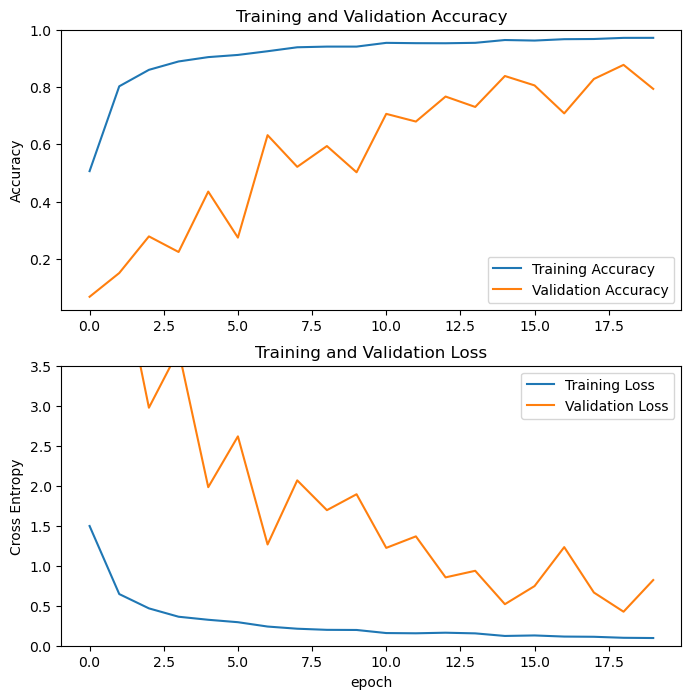

In [26]:
acc = mobile_net_classifier.history['acc']
val_acc = mobile_net_classifier.history['val_acc']

loss = mobile_net_classifier.history['loss']
val_loss = mobile_net_classifier.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()